In [1]:
from ThematicTextClassify.TextClassifier import *
from ThematicTextClassify.Preprocessing import *

/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df =pd.read_csv('Categorized_Links.csv')

# Preprocessing Text Function

In [3]:
# add the title and description column together to form a text document
df['Text'] = df['Title']+ df['Description']
df = df.dropna(subset= ['Text'], axis = 0)

# preprocess the newly defined Text column
df['Processed Text'] = df['Text'].map(preprocess_text)

df['processed_string'] =  [' '.join(text) for text in df['Processed Text']]

In [4]:
df['Class'] = ""
df['Class'] = df.apply(lambda df: 'Distribution' if (df['Category'] == 'Distribution') else df['Class'], axis =1)
df['Class'] = df.apply(lambda df: 'Other' if (df['Category'] != 'Distribution') else df['Class'], axis =1)
df = df.reset_index(drop=True)
df = df.sort_values('Class')
df = df.reset_index(drop=True)
df = df.drop_duplicates(['Link'],keep= 'first')
df = df.reset_index(drop=True)
len(df)

301

## Create Training and Test data 

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df,
                                                    df['Class'],
                                                    test_size=0.20, 
                                                    random_state=5131)

In [6]:
class_test.value_counts()

Other           50
Distribution    11
Name: Class, dtype: int64

In [7]:
df['Class'].value_counts()

Other           259
Distribution     42
Name: Class, dtype: int64

# Most Frequent words for Distribution

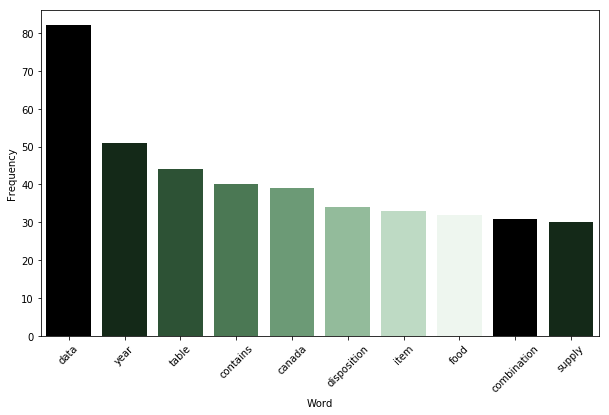

In [8]:
cv = CountVectorizer()
consumption = df[df['Class'] == 'Distribution']['processed_string']
bow_consumption = cv.fit_transform(consumption)
freq_consumption = dict(zip(cv.get_feature_names(), np.asarray(bow_consumption.sum(axis=0)).ravel()))
count_consumption = pd.DataFrame(collections.Counter(freq_consumption).most_common(10), columns = ['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(10, 6))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="Word", y="Frequency", data=count_consumption, palette=colour, ax=ax)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.show();

# General Check on Accuracy using CountVectorizer

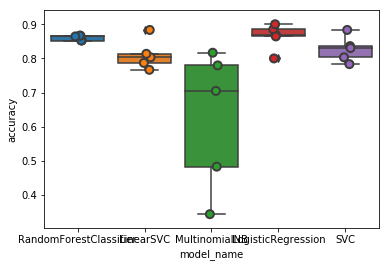

model_name
LinearSVC                 0.810745
LogisticRegression        0.863701
MultinomialNB             0.625768
RandomForestClassifier    0.860532
SVC                       0.827304
Name: accuracy, dtype: float64

In [10]:
countvect = CountVectorizer()
features = countvect.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 3000),MultinomialNB(),LogisticRegression(random_state=0),SVC(kernel ='linear', degree = 1, C = 0.25)]
cv_df = pd.DataFrame(index=range(5 * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# General Check on Accuracy using tfidf

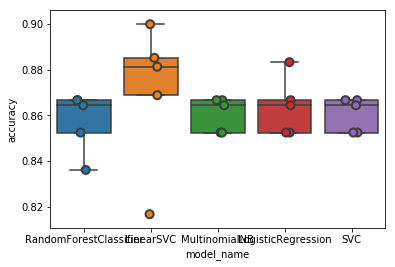

model_name
LinearSVC                 0.870424
LogisticRegression        0.863865
MultinomialNB             0.860532
RandomForestClassifier    0.857253
SVC                       0.860532
Name: accuracy, dtype: float64

In [11]:
tfidf = TfidfVectorizer() 
features = tfidf.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 3000),MultinomialNB(),LogisticRegression(random_state=0), SVC(kernel ='linear', degree = 1, C = 0.25)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# After comparing the cross validated accuracy of the models suppose we would like to use LinearSVC for our classifier, but we have yet to observe the performance indices and tune parameters

# Multinomial Naive Bayes (CountVectorizer)

In [12]:
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
mnb_countvect = grid_vect(mnb, param_mnb,text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   40.9s finished


done in 41.404s


Best CV score: 0.900
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 3)
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.50      0.36      0.42        11
       Other       0.87      0.92      0.89        50

    accuracy                           0.82        61
   macro avg       0.68      0.64      0.66        61
weighted avg       0.80      0.82      0.81        61

Accuracy Score:  0.819672131147541


# Multinomial Naive Bayes (TFIDF)

In [14]:
tfidf = TfidfVectorizer() 
mnb_countvect = grid_vect(mnb, param_mnb, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)


Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed:  2.5min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 151.170s


Best CV score: 0.904
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (2, 3)
	features__pipe__vect__norm: 'l2'
Cross Validated Test score with best_estimator_: 0.836


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.67      0.18      0.29        11
       Other       0.84      0.98      0.91        50

    accuracy                           0.84        61
   macro avg       0.76      0.58      0.60        61
weighted avg       0.81      0.84      0.80        61

Accuracy Score:  0.8360655737704918


# Logistic Regression (CountVectorizer)

In [14]:
logreg_countvect = grid_vect(logreg, param_logreg,text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.2min


done in 77.675s


Best CV score: 0.933
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.50      0.27      0.35        11
       Other       0.85      0.94      0.90        50

    accuracy                           0.82        61
   macro avg       0.68      0.61      0.62        61
weighted avg       0.79      0.82      0.80        61

Accuracy Score:  0.819672131147541


[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.3min finished


# Logisitc Regression (TFIDF)


In [15]:
logreg_tfidf = grid_vect(logreg, param_logreg, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)


Fitting 5 folds for each of 810 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed:  4.9min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  D

done in 295.912s


Best CV score: 0.929
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
	features__pipe__vect__norm: None
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.50      0.27      0.35        11
       Other       0.85      0.94      0.90        50

    accuracy                           0.82        61
   macro avg       0.68      0.61      0.62        61
weighted avg       0.79      0.82      0.80        61

Accuracy Score:  0.819672131147541


# Linear SVC (CountVectorizer)

In [16]:
linsvc = LinearSVC() 
lscv_countvect = grid_vect(linsvc, param_linearsvc, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect= countvect)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.1min finished


done in 67.604s


Best CV score: 0.925
Best parameters set:
	clf__C: 0.1
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.852


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.62      0.45      0.53        11
       Other       0.89      0.94      0.91        50

    accuracy                           0.85        61
   macro avg       0.76      0.70      0.72        61
weighted avg       0.84      0.85      0.84        61

Accuracy Score:  0.8524590163934426


# Linear SVC (TFIDF)

In [16]:
linsvc = LinearSVC() 
lscv_tfidf = grid_vect(linsvc, param_linearsvc,text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed:  4.0min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/chi/anaconda/lib/python3.6/site-packa

done in 242.618s


Best CV score: 0.917
Best parameters set:
	clf__C: 0.05
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 3)
	features__pipe__vect__norm: None
Cross Validated Test score with best_estimator_: 0.869


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.67      0.55      0.60        11
       Other       0.90      0.94      0.92        50

    accuracy                           0.87        61
   macro avg       0.79      0.74      0.76        61
weighted avg       0.86      0.87      0.86        61

Accuracy Score:  0.8688524590163934


# Random Forest Classifier (CountVectorizer)

In [18]:
RandF = RandomForestClassifier()
Randomforest_countvect = grid_vect(RandF, param_RandF, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 18.5min finished


done in 1112.901s


Best CV score: 0.875
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 200
	clf__random_state: 2
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 3)
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.00      0.00      0.00        11
       Other       0.82      1.00      0.90        50

    accuracy                           0.82        61
   macro avg       0.41      0.50      0.45        61
weighted avg       0.67      0.82      0.74        61

Accuracy Score:  0.819672131147541


# Random Forest Classifier (TFIDF)

In [9]:
RandF = RandomForestClassifier()
Randomforest_tfidf = grid_vect(RandF, param_RandF, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 24.2min finished


done in 1450.723s


Best CV score: 0.875
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 300
	clf__random_state: 3
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data




/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

Distribution       0.00      0.00      0.00        11
       Other       0.82      1.00      0.90        50

    accuracy                           0.82        61
   macro avg       0.41      0.50      0.45        61
weighted avg       0.67      0.82      0.74        61

Accuracy Score:  0.819672131147541


# XGboost (CountVectorizer)

In [10]:
countvect = CountVectorizer()
xgb = XGBClassifier(random_state=1995,colsample_bytree=0.3, subsample=0.3)
XGboost_tfidf = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 75.7min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 94.1min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 108.7min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: Deprecatio

done in 6523.090s


Best CV score: 0.921
Best parameters set:
	clf__max_depth: 5
	clf__seed: 1
	clf__subsample: 0.7
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.50      0.27      0.35        11
       Other       0.85      0.94      0.90        50

    accuracy                           0.82        61
   macro avg       0.68      0.61      0.62        61
weighted avg       0.79      0.82      0.80        61

Accuracy Score:  0.819672131147541


# XGboost (TFIDF)

In [11]:
XGboost_tfidf = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)



Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 49.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 72.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 79.6min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 86.1min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: Deprecation

done in 5165.264s


Best CV score: 0.925
Best parameters set:
	clf__max_depth: 7
	clf__seed: 2
	clf__subsample: 0.7
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.836


Classification Report Test Data


              precision    recall  f1-score   support

Distribution       0.57      0.36      0.44        11
       Other       0.87      0.94      0.90        50

    accuracy                           0.84        61
   macro avg       0.72      0.65      0.67        61
weighted avg       0.82      0.84      0.82        61

Accuracy Score:  0.8360655737704918
